In [1]:
import os
import pandas as pd
import numpy as np
import requests
import json
import glob
import re
import seaborn as sns
from matplotlib import pyplot as plt
from monty.serialization import loadfn

os.environ['BEEP_ENV'] = 'dev'

#Set to True if using charge_throughput, False if using cycle life/X.capacity_0.8
ct = True

__Reading in files__:

In [2]:
#Directories for old data DeltaQFastCharge and TrajectoryFastCharge
# old_d_dir = './FastCharge/data-share/features/DeltaQFastCharge'
# old_t_dir = './FastCharge/data-share/features/TrajectoryFastCharge'

#Directories for new data DeltaQFastCharge and TrajectoryFastCharge
# new_d_dir = "./NewData/DeltaQFastCharge/"
# new_t_dir = "./NewData/TrajectoryFastCharge/"

In [3]:
path = "E:/Data/TRI/"

old_subpath = "FastCharge/features/"

old_d_dir = path + old_subpath + "DeltaQFastCharge"
old_t_dir = path + old_subpath + "TrajectoryFastCharge"


new_subpath = "NewData/"

new_d_dir = path + new_subpath + "DeltaQFastCharge/"
new_t_dir = path + new_subpath + "TrajectoryFastCharge/"

In [4]:
def getListOfFiles(dirName):
    listOfFile = os.listdir(dirName)
    allFiles = list()
    for entry in listOfFile:
        fullPath = os.path.join(dirName, entry)
        if ".json" in fullPath:
            allFiles.append(fullPath)
    return allFiles

In [5]:
old_d_list = getListOfFiles(old_d_dir)
print(len(old_d_list))
old_d_list[:5]

139


['E:/Data/TRI/FastCharge/features/DeltaQFastCharge\\FastCharge_000000_CH19_features_DeltaQFastCharge.json',
 'E:/Data/TRI/FastCharge/features/DeltaQFastCharge\\FastCharge_000001_CH16_features_DeltaQFastCharge.json',
 'E:/Data/TRI/FastCharge/features/DeltaQFastCharge\\FastCharge_000001_CH30_features_DeltaQFastCharge.json',
 'E:/Data/TRI/FastCharge/features/DeltaQFastCharge\\FastCharge_000001_CH38_features_DeltaQFastCharge.json',
 'E:/Data/TRI/FastCharge/features/DeltaQFastCharge\\FastCharge_000002_CH10_features_DeltaQFastCharge.json']

In [6]:
old_t_list = getListOfFiles(old_t_dir)
print(len(old_t_list))
old_t_list[:5]

139


['E:/Data/TRI/FastCharge/features/TrajectoryFastCharge\\FastCharge_000000_CH19_features_TrajectoryFastCharge.json',
 'E:/Data/TRI/FastCharge/features/TrajectoryFastCharge\\FastCharge_000001_CH16_features_TrajectoryFastCharge.json',
 'E:/Data/TRI/FastCharge/features/TrajectoryFastCharge\\FastCharge_000001_CH30_features_TrajectoryFastCharge.json',
 'E:/Data/TRI/FastCharge/features/TrajectoryFastCharge\\FastCharge_000001_CH38_features_TrajectoryFastCharge.json',
 'E:/Data/TRI/FastCharge/features/TrajectoryFastCharge\\FastCharge_000002_CH10_features_TrajectoryFastCharge.json']

In [7]:
new_d_list = getListOfFiles(new_d_dir)
print(len(new_d_list))
new_d_list[:5]

30


['E:/Data/TRI/NewData/DeltaQFastCharge/LFP_15C_0-100_0.5-1C_a_CH00_features_DeltaQFastCharge.json',
 'E:/Data/TRI/NewData/DeltaQFastCharge/LFP_15C_0-100_0.5-1C_a_CH01_features_DeltaQFastCharge.json',
 'E:/Data/TRI/NewData/DeltaQFastCharge/LFP_15C_0-100_0.5-1C_a_CH02_features_DeltaQFastCharge.json',
 'E:/Data/TRI/NewData/DeltaQFastCharge/LFP_15C_0-100_0.5-1C_a_CH03_features_DeltaQFastCharge.json',
 'E:/Data/TRI/NewData/DeltaQFastCharge/LFP_15C_0-100_0.5-1C_a_CH04_features_DeltaQFastCharge.json']

In [8]:
new_t_list = getListOfFiles(new_t_dir)
print(len(new_t_list))
new_t_list[:5]

30


['E:/Data/TRI/NewData/TrajectoryFastCharge/LFP_15C_0-100_0.5-1C_a_CH00_features_TrajectoryFastCharge.json',
 'E:/Data/TRI/NewData/TrajectoryFastCharge/LFP_15C_0-100_0.5-1C_a_CH01_features_TrajectoryFastCharge.json',
 'E:/Data/TRI/NewData/TrajectoryFastCharge/LFP_15C_0-100_0.5-1C_a_CH02_features_TrajectoryFastCharge.json',
 'E:/Data/TRI/NewData/TrajectoryFastCharge/LFP_15C_0-100_0.5-1C_a_CH03_features_TrajectoryFastCharge.json',
 'E:/Data/TRI/NewData/TrajectoryFastCharge/LFP_15C_0-100_0.5-1C_a_CH04_features_TrajectoryFastCharge.json']

Combining DeltaQFastCharge and TrajectoryFastCharge:

In [9]:
def get_new_names(d_list):
    new_names = []
    for file in d_list:
        new_names.append(re.findall("CH(.*?)\_f", file)[0])
    return new_names
        
def make_df(file_list, batch=False):
    df = pd.DataFrame()
    for file in file_list:
        with open(file) as data_file:    
            data = json.load(data_file)
            data_df = pd.json_normalize(data)
            df = pd.concat([df,data_df])
    df.reset_index(drop=True,inplace=True)
    if batch:
        df['bat_num'] = get_new_names(file_list)
    return df

def merge_df(d_df, t_df):
    df_full = d_df.merge(t_df, left_index=True, right_index=True)

    # Making values not stored as lists
    for column in df_full.columns:
        if "X." in column:
            df_full[column] = df_full[column].apply(lambda x: x[0])

    df_full.reset_index(inplace=True)
    return df_full

__Old data__:

In [10]:
old_d_df = make_df(old_d_list, batch=True)
old_d_df.head()

,@module,@class,name,@version,X.discharge_capacity_cycle_2,X.max_discharge_capacity_difference,X.discharge_capacity_cycle_100,X.integrated_time_temperature_cycles_1:100,X.charge_time_cycles_1:5,X.abs_min_discharge_capacity_difference_cycles_2:100,...,X.internal_resistance_difference_cycles_2:100,X.nominal_capacity_by_median,metadata.barcode,metadata.protocol,metadata.channel_id,metadata.parameters.init_pred_cycle,metadata.parameters.mid_pred_cycle,metadata.parameters.final_pred_cycle,metadata.parameters.n_nominal_cycles,bat_num
0,beep.featurize,DeltaQFastCharge,/mnt/c/Users/sjrt1/Documents/School/Winter2021...,2021.1.11.15,[1.0454259],[0.8891461000000003],[1.0331815],[231072.4263671875],[614.4000244140625],[-1.1444158302992298],...,[-0.0010415539145469666],[1.047977],el150800440551,2017-06-30_tests\20170630-4_4C_55per_6C.sdu,18,10,91,100,40,19
1,beep.featurize,DeltaQFastCharge,/mnt/c/Users/sjrt1/Documents/School/Winter2021...,2021.1.11.15,[1.0620247999999999],[0.48970650000000004],[1.0439155],[149767.85131961218],[563.2000122070312],[-1.2773591296554208],...,[0.0003414759412407875],[1.06011365],el150800737229,2018-04-12_batch8\20180412-3_7C_31per_5_9C_new...,15,10,91,100,40,16
2,beep.featurize,DeltaQFastCharge,/mnt/c/Users/sjrt1/Documents/School/Winter2021...,2021.1.11.15,[1.0678786],[0.4961450999999999],[1.054091],[205315.4877278646],[614.4000244140625],[-1.3752393675218624],...,[0.00024036318063735962],[1.06736225],el150800737366,2018-04-12_batch8\20180412-3_7C_31per_5_9C_new...,29,10,91,100,40,30
3,beep.featurize,DeltaQFastCharge,/mnt/c/Users/sjrt1/Documents/School/Winter2021...,2021.1.11.15,[1.0512739],[0.49011190000000004],[1.0341983000000001],[159799.4890051929],[563.2000122070312],[-1.2430890844325302],...,[0.00042933784425258636],[1.05098615],el150800737234,2018-04-12_batch8\20180412-3_7C_31per_5_9C_new...,37,10,91,100,40,38
4,beep.featurize,DeltaQFastCharge,/mnt/c/Users/sjrt1/Documents/School/Winter2021...,2021.1.11.15,[1.0665728],[0.47571469999999993],[1.0695093],[146029.5250360061],[614.4000244140625],[-1.640443517452452],...,[-0.0001586293801665306],[1.0708095],el150800737329,2018-04-12_batch8\20180412-5C_67per_4C_newstru...,9,10,91,100,40,10


In [11]:
batches = []
for i in old_d_df['metadata.protocol']:
    if '2017-05' in i:
        batches.append('b1')
    elif '2017-06' in i:
        batches.append('b2')
    elif '2018-04' in i:
        batches.append('b3')

In [12]:
old_d_df['batches'] = batches
old_d_df['bat_name'] = old_d_df['batches'] + 'c' + old_d_df['bat_num']
old_d_df['bat_name']

0      b2c19
1      b3c16
2      b3c30
3      b3c38
4      b3c10
       ...  
134    b2c25
135    b2c46
136    b2c40
137    b2c34
138    b2c35
Name: bat_name, Length: 139, dtype: object

In [13]:
old_t_df = make_df(old_t_list)
old_t_df.head()

,@module,@class,name,@version,X.capacity_0.98,X.capacity_0.95,X.capacity_0.92,X.capacity_0.89,X.capacity_0.86,X.capacity_0.83,X.capacity_0.8,metadata.barcode,metadata.protocol,metadata.channel_id,metadata.parameters.thresh_max_cap,metadata.parameters.thresh_min_cap,metadata.parameters.interval_cap
0,beep.featurize,TrajectoryFastCharge,/mnt/c/Users/sjrt1/Documents/School/Winter2021...,2021.1.11.15,[127],[269],[376],[423],[449],[467],[483],el150800440551,2017-06-30_tests\20170630-4_4C_55per_6C.sdu,18,0.98,0.78,0.03
1,beep.featurize,TrajectoryFastCharge,/mnt/c/Users/sjrt1/Documents/School/Winter2021...,2021.1.11.15,[125],[276],[426],[528],[613],[668],[668],el150800737229,2018-04-12_batch8\20180412-3_7C_31per_5_9C_new...,15,0.98,0.78,0.03
2,beep.featurize,TrajectoryFastCharge,/mnt/c/Users/sjrt1/Documents/School/Winter2021...,2021.1.11.15,[774],[774],[774],[774],[774],[774],[774],el150800737366,2018-04-12_batch8\20180412-3_7C_31per_5_9C_new...,29,0.98,0.78,0.03
3,beep.featurize,TrajectoryFastCharge,/mnt/c/Users/sjrt1/Documents/School/Winter2021...,2021.1.11.15,[543],[543],[543],[543],[543],[543],[543],el150800737234,2018-04-12_batch8\20180412-3_7C_31per_5_9C_new...,37,0.98,0.78,0.03
4,beep.featurize,TrajectoryFastCharge,/mnt/c/Users/sjrt1/Documents/School/Winter2021...,2021.1.11.15,[1011],[1011],[1011],[1011],[1011],[1011],[1011],el150800737329,2018-04-12_batch8\20180412-5C_67per_4C_newstru...,9,0.98,0.78,0.03


In [14]:
old_df_full = merge_df(old_d_df, old_t_df)
old_df_full.sort_values(by=['bat_name'],inplace=True)
old_df_full.head()

,index,@module_x,@class_x,name_x,@version_x,X.discharge_capacity_cycle_2,X.max_discharge_capacity_difference,X.discharge_capacity_cycle_100,X.integrated_time_temperature_cycles_1:100,X.charge_time_cycles_1:5,...,X.capacity_0.89,X.capacity_0.86,X.capacity_0.83,X.capacity_0.8,metadata.barcode_y,metadata.protocol_y,metadata.channel_id_y,metadata.parameters.thresh_max_cap,metadata.parameters.thresh_min_cap,metadata.parameters.interval_cap
98,98,beep.featurize,DeltaQFastCharge,/mnt/c/Users/sjrt1/Documents/School/Winter2021...,2021.1.11.15,1.069159,0.609605,1.075878,194523.331238,768.000000,...,1191,1191,1191,1191,EL150800460514,2017-05-12_TESTS\20170512-3_6C-80PER_3_6C.SDU,0,0.98,0.78,0.03
13,13,beep.featurize,DeltaQFastCharge,/mnt/c/Users/sjrt1/Documents/School/Winter2021...,2021.1.11.15,1.021925,0.234529,1.010972,163310.066862,819.200012,...,528,663,665,665,EL150800460514,2017-05-12_TESTS\20170512-3_6C-80PER_3_6C.SDU,0,0.98,0.78,0.03
78,78,beep.featurize,DeltaQFastCharge,/mnt/c/Users/sjrt1/Documents/School/Winter2021...,2021.1.11.15,1.072973,0.607773,1.079325,182982.491752,563.200012,...,583,605,625,638,EL150800463886,2017-05-12_TESTS\20170512-4_8C-80PER_4_8C.SDU,9,0.98,0.78,0.03
96,96,beep.featurize,DeltaQFastCharge,/mnt/c/Users/sjrt1/Documents/School/Winter2021...,2021.1.11.15,1.070200,0.609325,1.061485,178767.125004,537.599976,...,441,492,525,536,EL150800464002,2017-05-12_TESTS\20170512-5_4C-80PER_5_4C.SDU,10,0.98,0.78,0.03
97,97,beep.featurize,DeltaQFastCharge,/mnt/c/Users/sjrt1/Documents/School/Winter2021...,2021.1.11.15,1.080072,0.606653,1.076906,184036.176107,512.000000,...,492,526,549,561,EL150800463871,2017-05-12_TESTS\20170512-5_4C-80PER_5_4C.SDU,11,0.98,0.78,0.03


In [15]:
old_df_full.keys()

Index(['index', '@module_x', '@class_x', 'name_x', '@version_x',
       'X.discharge_capacity_cycle_2', 'X.max_discharge_capacity_difference',
       'X.discharge_capacity_cycle_100',
       'X.integrated_time_temperature_cycles_1:100',
       'X.charge_time_cycles_1:5',
       'X.abs_min_discharge_capacity_difference_cycles_2:100',
       'X.abs_mean_discharge_capacity_difference_cycles_2:100',
       'X.abs_variance_discharge_capacity_difference_cycles_2:100',
       'X.abs_skew_discharge_capacity_difference_cycles_2:100',
       'X.abs_kurtosis_discharge_capacity_difference_cycles_2:100',
       'X.abs_first_discharge_capacity_difference_cycles_2:100',
       'X.max_temperature_cycles_1:100', 'X.min_temperature_cycles_1:100',
       'X.slope_discharge_capacity_cycle_number_2:100',
       'X.intercept_discharge_capacity_cycle_number_2:100',
       'X.slope_discharge_capacity_cycle_number_91:100',
       'X.intercept_discharge_capacity_cycle_number_91:100',
       'X.min_internal_resi

In [16]:
print(min(old_df_full['X.capacity_0.8']))
print(max(old_df_full['X.capacity_0.8']))

161
2239


__New data__:

In [17]:
new_d_df = make_df(new_d_list, batch=True)
new_d_df.head()

,@module,@class,name,@version,X.discharge_capacity_cycle_2,X.max_discharge_capacity_difference,X.discharge_capacity_cycle_100,X.integrated_time_temperature_cycles_1:100,X.charge_time_cycles_1:5,X.abs_min_discharge_capacity_difference_cycles_2:100,...,X.internal_resistance_difference_cycles_2:100,X.nominal_capacity_by_median,metadata.barcode,metadata.protocol,metadata.channel_id,metadata.parameters.init_pred_cycle,metadata.parameters.mid_pred_cycle,metadata.parameters.final_pred_cycle,metadata.parameters.n_nominal_cycles,bat_num
0,beep.featurize,DeltaQFastCharge,C:\Users\mattm\Documents\CalPoly\DATA 451\Toyo...,2021.1.11.15,[1.03],[1.035],[1.032],[306697.58829142264],[5760.0],[-0.44680629485828904],...,[nan],[1.033],None,None,None,10,91,100,40,00
1,beep.featurize,DeltaQFastCharge,C:\Users\mattm\Documents\CalPoly\DATA 451\Toyo...,2021.1.11.15,[1.04],[1.0430000000000001],[1.042],[296427.4028991698],[5785.60009765625],[-0.20877572651236104],...,[nan],[1.044],None,None,None,10,91,100,40,01
2,beep.featurize,DeltaQFastCharge,C:\Users\mattm\Documents\CalPoly\DATA 451\Toyo...,2021.1.11.15,[1.03],[1.0290000000000001],[1.03],[262556.75055948895],[5811.2001953125],[-0.19563143967312835],...,[nan],[1.031],None,None,None,10,91,100,40,02
3,beep.featurize,DeltaQFastCharge,C:\Users\mattm\Documents\CalPoly\DATA 451\Toyo...,2021.1.11.15,[1.029],[1.0260000000000002],[1.025],[268508.7274637858],[5785.60009765625],[-0.6317302807027921],...,[nan],[1.028],None,None,None,10,91,100,40,03
4,beep.featurize,DeltaQFastCharge,C:\Users\mattm\Documents\CalPoly\DATA 451\Toyo...,2021.1.11.15,[1.067],[1.074],[1.0590000000000002],[614925.4964558918],[5785.60009765625],[-0.1893985483034041],...,[nan],[1.067],None,None,None,10,91,100,40,04


In [18]:
new_t_df = make_df(new_t_list)
new_t_df.head()

,@module,@class,name,@version,X.capacity_0.98,X.capacity_0.95,X.capacity_0.92,X.capacity_0.89,X.capacity_0.86,X.capacity_0.83,X.capacity_0.8,metadata.barcode,metadata.protocol,metadata.channel_id,metadata.parameters.thresh_max_cap,metadata.parameters.thresh_min_cap,metadata.parameters.interval_cap
0,beep.featurize,TrajectoryFastCharge,C:\Users\mattm\Documents\CalPoly\DATA 451\Toyo...,2021.1.11.15,[506.0],[506.0],[506.0],[4550.0],[4550.0],[4550.0],[4550.0],None,None,None,0.98,0.78,0.03
1,beep.featurize,TrajectoryFastCharge,C:\Users\mattm\Documents\CalPoly\DATA 451\Toyo...,2021.1.11.15,[506.0],[506.0],[3552.0],[3552.0],[3552.0],[3552.0],[3552.0],None,None,None,0.98,0.78,0.03
2,beep.featurize,TrajectoryFastCharge,C:\Users\mattm\Documents\CalPoly\DATA 451\Toyo...,2021.1.11.15,[506.0],[506.0],[506.0],[3760.0],[3760.0],[3760.0],[3760.0],None,None,None,0.98,0.78,0.03
3,beep.featurize,TrajectoryFastCharge,C:\Users\mattm\Documents\CalPoly\DATA 451\Toyo...,2021.1.11.15,[506.0],[506.0],[506.0],[3753.0],[3753.0],[3753.0],[3753.0],None,None,None,0.98,0.78,0.03
4,beep.featurize,TrajectoryFastCharge,C:\Users\mattm\Documents\CalPoly\DATA 451\Toyo...,2021.1.11.15,[207.0],[207.0],[207.0],[3049.0],[3049.0],[3049.0],[3049.0],None,None,None,0.98,0.78,0.03


In [19]:
new_df_full = merge_df(new_d_df, new_t_df)
new_df_full.head()

,index,@module_x,@class_x,name_x,@version_x,X.discharge_capacity_cycle_2,X.max_discharge_capacity_difference,X.discharge_capacity_cycle_100,X.integrated_time_temperature_cycles_1:100,X.charge_time_cycles_1:5,...,X.capacity_0.89,X.capacity_0.86,X.capacity_0.83,X.capacity_0.8,metadata.barcode_y,metadata.protocol_y,metadata.channel_id_y,metadata.parameters.thresh_max_cap,metadata.parameters.thresh_min_cap,metadata.parameters.interval_cap
0,0,beep.featurize,DeltaQFastCharge,C:\Users\mattm\Documents\CalPoly\DATA 451\Toyo...,2021.1.11.15,1.030,1.035,1.032,306697.588291,5760.000000,...,4550.0,4550.0,4550.0,4550.0,None,None,None,0.98,0.78,0.03
1,1,beep.featurize,DeltaQFastCharge,C:\Users\mattm\Documents\CalPoly\DATA 451\Toyo...,2021.1.11.15,1.040,1.043,1.042,296427.402899,5785.600098,...,3552.0,3552.0,3552.0,3552.0,None,None,None,0.98,0.78,0.03
2,2,beep.featurize,DeltaQFastCharge,C:\Users\mattm\Documents\CalPoly\DATA 451\Toyo...,2021.1.11.15,1.030,1.029,1.030,262556.750559,5811.200195,...,3760.0,3760.0,3760.0,3760.0,None,None,None,0.98,0.78,0.03
3,3,beep.featurize,DeltaQFastCharge,C:\Users\mattm\Documents\CalPoly\DATA 451\Toyo...,2021.1.11.15,1.029,1.026,1.025,268508.727464,5785.600098,...,3753.0,3753.0,3753.0,3753.0,None,None,None,0.98,0.78,0.03
4,4,beep.featurize,DeltaQFastCharge,C:\Users\mattm\Documents\CalPoly\DATA 451\Toyo...,2021.1.11.15,1.067,1.074,1.059,614925.496456,5785.600098,...,3049.0,3049.0,3049.0,3049.0,None,None,None,0.98,0.78,0.03


In [20]:
new_df_full["name_x"][0]

'C:\\Users\\mattm\\Documents\\CalPoly\\DATA 451\\Toyota\\DeltaQFastCharge\\LFP_15C_0-100_0.5-1C_a_CH00_features_DeltaQFastCharge.json'

__Adding Charge Throughput__

In [22]:
if ct:
    old_ct = pd.read_csv(path + "OldData/OldDataFullCT.csv")
    new_ct = pd.read_csv(path + "NewData/charge_throughputs_BA.csv")

In [23]:
if ct:
    old_ct = old_ct.filter(["name_x", "X.capacity_0.8", "charge_throughput"])
    old_ct.rename(columns={"X.capacity_0.8": "cycle_index"}, inplace=True)

In [24]:
if ct:
    old_df_full = old_df_full.merge(old_ct, on="name_x", how="left")
    
    battery = new_df_full["name_x"].str.split("\\").apply(lambda x: x[-1])
    battery = battery.str.split("_features_").apply(lambda x: x[0])
    new_df_full["battery"] = battery
    
    new_df_full = new_df_full.merge(new_ct, on="battery", how="left")

In [25]:
if ct:
    display(old_df_full.head())
    display(new_df_full.head())

,index,@module_x,@class_x,name_x,@version_x,X.discharge_capacity_cycle_2,X.max_discharge_capacity_difference,X.discharge_capacity_cycle_100,X.integrated_time_temperature_cycles_1:100,X.charge_time_cycles_1:5,...,X.capacity_0.83,X.capacity_0.8,metadata.barcode_y,metadata.protocol_y,metadata.channel_id_y,metadata.parameters.thresh_max_cap,metadata.parameters.thresh_min_cap,metadata.parameters.interval_cap,cycle_index,charge_throughput
0,98,beep.featurize,DeltaQFastCharge,/mnt/c/Users/sjrt1/Documents/School/Winter2021...,2021.1.11.15,1.069159,0.609605,1.075878,194523.331238,768.000000,...,1191,1191,EL150800460514,2017-05-12_TESTS\20170512-3_6C-80PER_3_6C.SDU,0,0.98,0.78,0.03,1191,1254.091309
1,13,beep.featurize,DeltaQFastCharge,/mnt/c/Users/sjrt1/Documents/School/Winter2021...,2021.1.11.15,1.021925,0.234529,1.010972,163310.066862,819.200012,...,665,665,EL150800460514,2017-05-12_TESTS\20170512-3_6C-80PER_3_6C.SDU,0,0.98,0.78,0.03,665,639.746826
2,78,beep.featurize,DeltaQFastCharge,/mnt/c/Users/sjrt1/Documents/School/Winter2021...,2021.1.11.15,1.072973,0.607773,1.079325,182982.491752,563.200012,...,625,638,EL150800463886,2017-05-12_TESTS\20170512-4_8C-80PER_4_8C.SDU,9,0.98,0.78,0.03,638,664.310181
3,96,beep.featurize,DeltaQFastCharge,/mnt/c/Users/sjrt1/Documents/School/Winter2021...,2021.1.11.15,1.070200,0.609325,1.061485,178767.125004,537.599976,...,525,536,EL150800464002,2017-05-12_TESTS\20170512-5_4C-80PER_5_4C.SDU,10,0.98,0.78,0.03,536,539.480530
4,97,beep.featurize,DeltaQFastCharge,/mnt/c/Users/sjrt1/Documents/School/Winter2021...,2021.1.11.15,1.080072,0.606653,1.076906,184036.176107,512.000000,...,549,561,EL150800463871,2017-05-12_TESTS\20170512-5_4C-80PER_5_4C.SDU,11,0.98,0.78,0.03,561,576.926392


,index,@module_x,@class_x,name_x,@version_x,X.discharge_capacity_cycle_2,X.max_discharge_capacity_difference,X.discharge_capacity_cycle_100,X.integrated_time_temperature_cycles_1:100,X.charge_time_cycles_1:5,...,X.capacity_0.8,metadata.barcode_y,metadata.protocol_y,metadata.channel_id_y,metadata.parameters.thresh_max_cap,metadata.parameters.thresh_min_cap,metadata.parameters.interval_cap,battery,charge_throughput,cycle_index
0,0,beep.featurize,DeltaQFastCharge,C:\Users\mattm\Documents\CalPoly\DATA 451\Toyo...,2021.1.11.15,1.030,1.035,1.032,306697.588291,5760.000000,...,4550.0,None,None,None,0.98,0.78,0.03,LFP_15C_0-100_0.5-1C_a_CH00,4524.021,4550.0
1,1,beep.featurize,DeltaQFastCharge,C:\Users\mattm\Documents\CalPoly\DATA 451\Toyo...,2021.1.11.15,1.040,1.043,1.042,296427.402899,5785.600098,...,3552.0,None,None,None,0.98,0.78,0.03,LFP_15C_0-100_0.5-1C_a_CH01,3577.625,3552.0
2,2,beep.featurize,DeltaQFastCharge,C:\Users\mattm\Documents\CalPoly\DATA 451\Toyo...,2021.1.11.15,1.030,1.029,1.030,262556.750559,5811.200195,...,3760.0,None,None,None,0.98,0.78,0.03,LFP_15C_0-100_0.5-1C_a_CH02,3680.164,3760.0
3,3,beep.featurize,DeltaQFastCharge,C:\Users\mattm\Documents\CalPoly\DATA 451\Toyo...,2021.1.11.15,1.029,1.026,1.025,268508.727464,5785.600098,...,3753.0,None,None,None,0.98,0.78,0.03,LFP_15C_0-100_0.5-1C_a_CH03,3655.051,3753.0
4,4,beep.featurize,DeltaQFastCharge,C:\Users\mattm\Documents\CalPoly\DATA 451\Toyo...,2021.1.11.15,1.067,1.074,1.059,614925.496456,5785.600098,...,3049.0,None,None,None,0.98,0.78,0.03,LFP_15C_0-100_0.5-1C_a_CH04,3058.955,3049.0


__Model Recreation__:

In [26]:
variance_model_features = 'X.abs_variance_discharge_capacity_difference_cycles_2:100'
discharge_model_features = ['X.abs_min_discharge_capacity_difference_cycles_2:100',
                            'X.abs_variance_discharge_capacity_difference_cycles_2:100',
                            'X.abs_skew_discharge_capacity_difference_cycles_2:100',
                            'X.abs_kurtosis_discharge_capacity_difference_cycles_2:100',
                            'X.discharge_capacity_cycle_2',
                            'X.max_discharge_capacity_difference'
                            ]
full_model_features = ['X.abs_min_discharge_capacity_difference_cycles_2:100',
                       'X.abs_variance_discharge_capacity_difference_cycles_2:100',
                       'X.slope_discharge_capacity_cycle_number_2:100',
                       'X.intercept_discharge_capacity_cycle_number_2:100',
                       'X.discharge_capacity_cycle_2',
                       'X.charge_time_cycles_1:5',
                       'X.integrated_time_temperature_cycles_1:100']
#                        'X.min_internal_resistance_cycles_2:100',
#                        'X.internal_resistance_difference_cycles_2:100']

internal_resistance = ['X.min_internal_resistance_cycles_2:100', 
                       'X.internal_resistance_difference_cycles_2:100']

if ct:
    y = 'charge_throughput'
else:
    y = 'X.capacity_0.8'

__Old Data Models__

In [27]:
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

<AxesSubplot:xlabel='X.abs_variance_discharge_capacity_difference_cycles_2:100', ylabel='charge_throughput'>

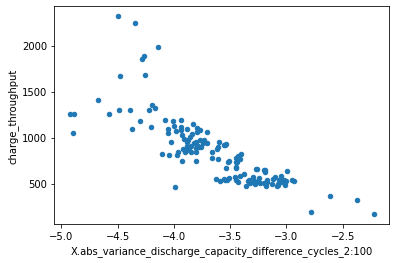

In [28]:
old_df_full.plot.scatter(x='X.abs_variance_discharge_capacity_difference_cycles_2:100', y = y)

In [29]:
train_ind = [ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
        35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
        69, 71, 73, 75, 77, 79, 81]
test_ind = [ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
        34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
        68, 70, 72, 74, 76, 78, 80, 82, 83]

In [30]:
# Variance model
X_train_var = old_df_full.iloc[train_ind][[variance_model_features]]
y_train = old_df_full.iloc[train_ind][[y]]

X_test_var = old_df_full.iloc[test_ind][[variance_model_features]]
y_test = old_df_full.iloc[test_ind][[y]]

In [31]:
reg_var = LinearRegression().fit(X_train_var,y_train)
y_pred_train_var = reg_var.predict(X_train_var)
y_pred_test_var = reg_var.predict(X_test_var)

rmse_train_var = np.sqrt(mean_squared_error(y_train, y_pred_train_var))
rmse_test_var = np.sqrt(mean_squared_error(y_test, y_pred_test_var))
mape_train_var = mean_absolute_percentage_error(y_train, y_pred_train_var)
mape_test_var = mean_absolute_percentage_error(y_test, y_pred_test_var)

print("Variance Basic Linear Regression Model")
print("Training RMSE: ", rmse_train_var)
print("Test RMSE: ", rmse_test_var)
print("Mean % Train Error: ", mape_train_var)
print("Mean % Test Error: ", mape_test_var)

Variance Basic Linear Regression Model
Training RMSE:  139.78172089014936
Test RMSE:  133.31259554173022
Mean % Train Error:  0.17837454805087002
Mean % Test Error:  0.1613901025355763


Text(0.5, 1.0, 'Variance Model Predicted vs. True Values')

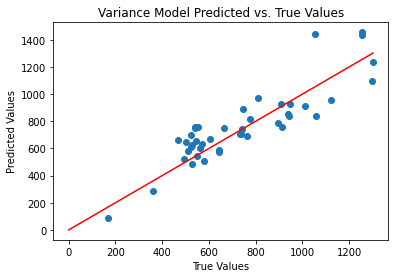

In [32]:
# Variance model
min_var = y_test.min()[0]
max_var = y_test.max()[0]

plt.scatter(y_test, y_pred_test_var)
plt.plot([0, max_var], [0, max_var], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Variance Model Predicted vs. True Values")

In [33]:
k_fold = 5
l1_ratios = [i/20 for i in range(10, 21)]
max_iter = 1000000
random_state = 1
test_size = 2
tol = 0.0001

models = []
y_pred_trains = []
y_pred_tests = []
train_rmses = []
test_rmses = []

for l1_ratio in l1_ratios:
    elasticnetcv = ElasticNetCV(
        fit_intercept=True,
        normalize=False,
        alphas=None,
        cv=k_fold,
        l1_ratio=l1_ratio,
        max_iter=max_iter,
    )
    elasticnetcv.fit(X_train_var, y_train)

    elasticnet_var = ElasticNet(
        fit_intercept=True,
        normalize=False,
        l1_ratio=elasticnetcv.l1_ratio_,
        alpha=elasticnetcv.alpha_,
        max_iter=max_iter,
    )

    elasticnet_var.fit(X_train_var, y_train)
    y_pred_train_en_var = elasticnet_var.predict(X_train_var)
    y_pred_test_en_var = elasticnet_var.predict(X_test_var)

    rmse_train_en_var = np.sqrt(mean_squared_error(y_train, y_pred_train_en_var))
    rmse_test_en_var = np.sqrt(mean_squared_error(y_test, y_pred_test_en_var))
#     mape_train_en_var = mean_absolute_percentage_error(y_train, y_pred_train_en_var)
#     mape_test_en_var = mean_absolute_percentage_error(y_test, y_pred_test_en_var)

    models.append(elasticnet_var)
    y_pred_trains.append(y_pred_train_en_var)
    y_pred_tests.append(y_pred_test_en_var)
    train_rmses.append(rmse_train_en_var)
    test_rmses.append(rmse_test_en_var)

best_model_index = test_rmses.index(min(test_rmses))

elasticnet_var = models[best_model_index]
y_pred_train_en_var = y_pred_trains[best_model_index]
y_pred_test_en_var = y_pred_tests[best_model_index]
rmse_train_var_en = train_rmses[best_model_index]
rmse_test_var_en = test_rmses[best_model_index]
l1_ratio_var = l1_ratios[best_model_index]

print("Variance Elastic Net Model")
print("l1_ratio =", l1_ratio_var)
print("Test RMSE: ", rmse_test_var_en)

C:\Users\david\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\david\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\david\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\david\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

Variance Elastic Net Model
l1_ratio = 0.75
Test RMSE:  126.95868497377425


C:\Users\david\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


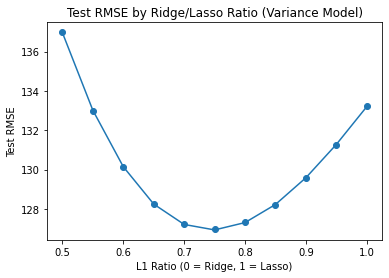

In [34]:
coeffs = np.polyfit(l1_ratios, test_rmses, 3)
vals = [coeffs[0]*val**3 + coeffs[1]*val**2 + coeffs[2]*val + coeffs[3] for val in l1_ratios]

plt.scatter(l1_ratios, test_rmses)
plt.plot(l1_ratios, vals)
plt.title("Test RMSE by Ridge/Lasso Ratio (Variance Model)")
plt.xlabel("L1 Ratio (0 = Ridge, 1 = Lasso)")
plt.ylabel("Test RMSE");

#### From paper (Variance Model)
* Training RMSE: 103
* Test RMSE: 138
* Mean % Train Error: 14.1
* Mean % Test Error: 14.7

In [35]:
# discharge model
X_train_dis = old_df_full.iloc[train_ind][discharge_model_features]
y_train = old_df_full.iloc[train_ind][[y]]

X_test_dis = old_df_full.iloc[test_ind][discharge_model_features]
y_test = old_df_full.iloc[test_ind][[y]]

reg_dis = LinearRegression().fit(X_train_dis,y_train)
y_pred_train_dis = reg_dis.predict(X_train_dis)
y_pred_test_dis = reg_dis.predict(X_test_dis)

rmse_train_dis = np.sqrt(mean_squared_error(y_train, y_pred_train_dis))
rmse_test_dis = np.sqrt(mean_squared_error(y_test, y_pred_test_dis))
mape_train_dis = mean_absolute_percentage_error(y_train, y_pred_train_dis)
mape_test_dis = mean_absolute_percentage_error(y_test, y_pred_test_dis)

print("Discharge Basic Linear Regression Model")
print("Training RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_train_dis)))
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_test_dis)))
# print("Mean % Train Error: ", mean_absolute_percentage_error(y_train, y_pred_train_dis))
# print("Mean % Test Error: ", mean_absolute_percentage_error(y_test, y_pred_test_dis))

Discharge Basic Linear Regression Model
Training RMSE:  76.21601759919676
Test RMSE:  92.8739752809801


Text(0.5, 1.0, 'Discharge Model Predicted vs. True Values')

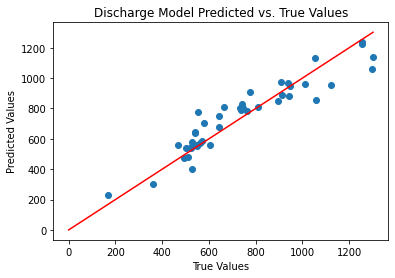

In [36]:
# Discharge model
max_dis = y_test.max()[0]

plt.scatter(y_test, y_pred_test_dis)
plt.plot([0, max_dis], [0, max_dis], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Discharge Model Predicted vs. True Values")

In [37]:
k_fold = 5
l1_ratios = [i/20 for i in range(10, 21)]
max_iter = 1000000
random_state = 1
test_size = 2
tol = 0.0001

models = []
y_pred_trains = []
y_pred_tests = []
train_rmses = []
test_rmses = []

for l1_ratio in l1_ratios:
    elasticnetcv = ElasticNetCV(
        fit_intercept=True,
        normalize=False,
        alphas=None,
        cv=k_fold,
        l1_ratio=l1_ratio,
        max_iter=max_iter,
    )
    elasticnetcv.fit(X_train_dis, y_train)

    elasticnet_dis = ElasticNet(
        fit_intercept=True,
        normalize=False,
        l1_ratio=elasticnetcv.l1_ratio_,
        alpha=elasticnetcv.alpha_,
        max_iter=max_iter,
    )

    elasticnet_dis.fit(X_train_dis, y_train)
    y_pred_train_en_dis = elasticnet_dis.predict(X_train_dis)
    y_pred_test_en_dis = elasticnet_dis.predict(X_test_dis)

    rmse_train_en_dis = np.sqrt(mean_squared_error(y_train, y_pred_train_en_dis))
    rmse_test_en_dis = np.sqrt(mean_squared_error(y_test, y_pred_test_en_dis))
#     mape_train_en_dis = mean_absolute_percentage_error(y_train, y_pred_train_en_dis)
#     mape_test_en_dis = mean_absolute_percentage_error(y_test, y_pred_test_en_dis)

    models.append(elasticnet_dis)
    y_pred_trains.append(y_pred_train_en_dis)
    y_pred_tests.append(y_pred_test_en_dis)
    train_rmses.append(rmse_train_en_dis)
    test_rmses.append(rmse_test_en_dis)

best_model_index = test_rmses.index(min(test_rmses))

elasticnet_dis = models[best_model_index]
y_pred_train_en_dis = y_pred_trains[best_model_index]
y_pred_test_en_dis = y_pred_tests[best_model_index]
rmse_train_dis_en = train_rmses[best_model_index]
rmse_test_dis_en = test_rmses[best_model_index]
l1_ratio_dis = l1_ratios[best_model_index]

print("Discharge Elastic Net Model")
print("l1_ratio =", l1_ratio_dis)
print("Test RMSE: ", rmse_test_dis_en)

C:\Users\david\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\david\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\david\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\david\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

Discharge Elastic Net Model
l1_ratio = 1.0
Test RMSE:  91.59269841097976


C:\Users\david\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [38]:
test_rmses

[123.01660785564435,
 119.44761011734857,
 116.8905687295295,
 115.17191728416866,
 114.12934682049308,
 113.57036523416309,
 113.42465704589301,
 113.41219471558333,
 113.41808633223333,
 113.43621304945097,
 91.59269841097976]

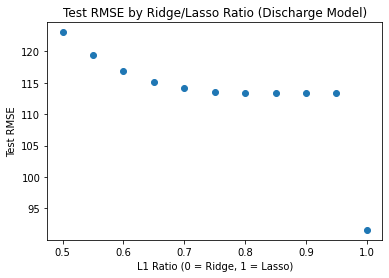

In [39]:
# coeffs = np.polyfit(l1_ratios, test_rmses, 3)
# vals = [coeffs[0]*val**3 + coeffs[1]*val**2 + coeffs[2]*val + coeffs[3] for val in l1_ratios[:-1]]

plt.scatter(l1_ratios, test_rmses)
# plt.plot(l1_ratios[:-1], vals)
plt.title("Test RMSE by Ridge/Lasso Ratio (Discharge Model)")
plt.xlabel("L1 Ratio (0 = Ridge, 1 = Lasso)")
plt.ylabel("Test RMSE");

#### From paper (Discharge Model)
* Training RMSE: 76
* Test RMSE: 91
* Mean % Train Error: 9.8
* Mean % Test Error: 13.0

In [40]:
# full model
X_train_full = old_df_full.iloc[train_ind][full_model_features + internal_resistance]
y_train = old_df_full.iloc[train_ind][[y]]

X_test_full = old_df_full.iloc[test_ind][full_model_features + internal_resistance]
y_test = old_df_full.iloc[test_ind][[y]]

reg_full = LinearRegression().fit(X_train_full,y_train)
y_pred_train_full = reg_full.predict(X_train_full)
y_pred_test_full = reg_full.predict(X_test_full)

rmse_train_full = np.sqrt(mean_squared_error(y_train, y_pred_train_full))
rmse_test_full = np.sqrt(mean_squared_error(y_test, y_pred_test_full))
mape_train_full = mean_absolute_percentage_error(y_train, y_pred_train_full)
mape_test_full = mean_absolute_percentage_error(y_test, y_pred_test_full)

print("Full Basic Linear Regression Model")
print("Training RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_train_full)))
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_test_full)))
print("Mean % Train Error: ", mean_absolute_percentage_error(y_train, y_pred_train_full))
print("Mean % Test Error: ", mean_absolute_percentage_error(y_test, y_pred_test_full))

Full Basic Linear Regression Model
Training RMSE:  71.82779934565669
Test RMSE:  104.94026134379268
Mean % Train Error:  0.08014643697136324
Mean % Test Error:  0.11201905211734381


Text(0.5, 1.0, 'Full Model Predicted vs. True Values')

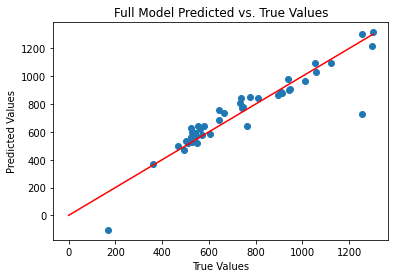

In [41]:
min_full = y_test.min()[0]
max_full = y_test.max()[0]

plt.scatter(y_test, y_pred_test_full)
plt.plot([0, max_full], [0, max_full], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Full Model Predicted vs. True Values")

In [42]:
k_fold = 5
l1_ratios = [i/20 for i in range(1, 21)]   #use this when testing different ratios
#l1_ratios = [0.8]   #use this when using only the best ratio
max_iter = 1000000
random_state = 1
test_size = 2
tol = 0.0001

models = []
y_pred_trains = []
y_pred_tests = []
train_rmses = []
test_rmses = []

for l1_ratio in l1_ratios:
    elasticnetcv = ElasticNetCV(
        fit_intercept=True,
        normalize=False,
        alphas=None,
        cv=k_fold,
        l1_ratio=l1_ratio,
        max_iter=max_iter,
    )
    elasticnetcv.fit(X_train_full, y_train)

    elasticnet_full = ElasticNet(
        fit_intercept=True,
        normalize=False,
        l1_ratio=elasticnetcv.l1_ratio_,
        alpha=elasticnetcv.alpha_,
        max_iter=max_iter,
    )

    elasticnet_full.fit(X_train_full, y_train)
    y_pred_train_en_full = elasticnet_full.predict(X_train_full)
    y_pred_test_en_full = elasticnet_full.predict(X_test_full)

    rmse_train_en_full = np.sqrt(mean_squared_error(y_train, y_pred_train_en_full))
    rmse_test_en_full = np.sqrt(mean_squared_error(y_test, y_pred_test_en_full))
#     mape_train_en_full = mean_absolute_percentage_error(y_train, y_pred_train_en_full)
#     mape_test_en_full = mean_absolute_percentage_error(y_test, y_pred_test_en_full)

    models.append(elasticnet_full)
    y_pred_trains.append(y_pred_train_en_full)
    y_pred_tests.append(y_pred_test_en_full)
    train_rmses.append(rmse_train_en_full)
    test_rmses.append(rmse_test_en_full)

best_model_index = test_rmses.index(min(test_rmses))

elasticnet_full = models[best_model_index]
y_pred_train_en_full = y_pred_trains[best_model_index]
y_pred_test_en_full = y_pred_tests[best_model_index]
rmse_train_full_en = train_rmses[best_model_index]
rmse_test_full_en = test_rmses[best_model_index]
l1_ratio_full = l1_ratios[best_model_index]

print("Full Elastic Net Model")
print("l1_ratio =", l1_ratio_full)
print("Test RMSE: ", rmse_test_full_en)

C:\Users\david\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\david\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\david\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\david\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

Full Elastic Net Model
l1_ratio = 1.0
Test RMSE:  218.48930577553458


C:\Users\david\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


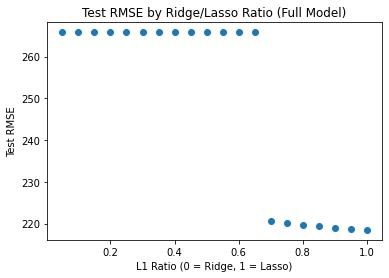

In [43]:
plt.scatter(l1_ratios, test_rmses)
plt.title("Test RMSE by Ridge/Lasso Ratio (Full Model)")
plt.xlabel("L1 Ratio (0 = Ridge, 1 = Lasso)")
plt.ylabel("Test RMSE");

#### From paper (Full Model)
* Training RMSE: 51
* Test RMSE: 118
* Mean % Train Error: 5.6
* Mean % Test Error: 14.1

__Old Data Plots__

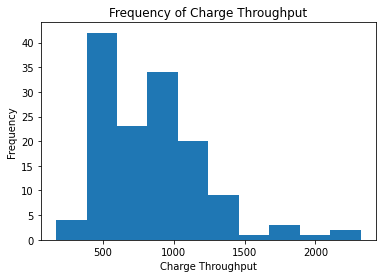

In [44]:
plt.hist(old_df_full[y])
plt.ylabel('Frequency')
if ct:
    plt.xlabel('Charge Throughput')
    plt.title('Frequency of Charge Throughput')
else:
    plt.xlabel('Cycle Life')
    plt.title('Frequency of Cycle Life')

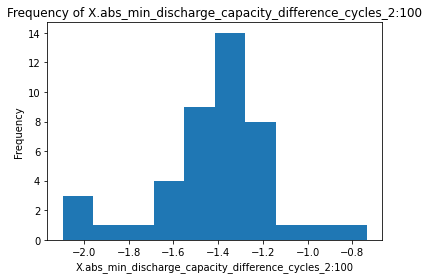

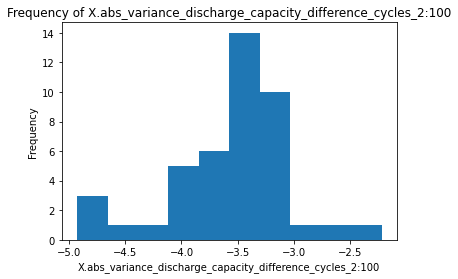

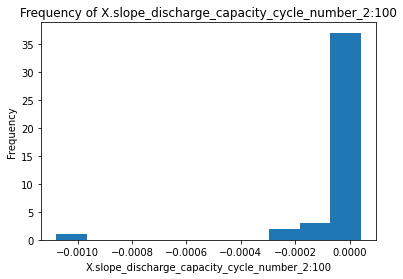

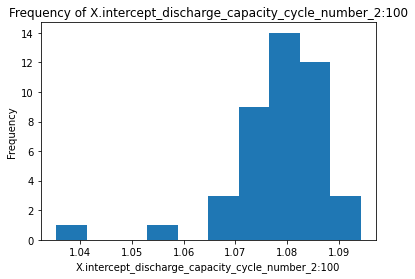

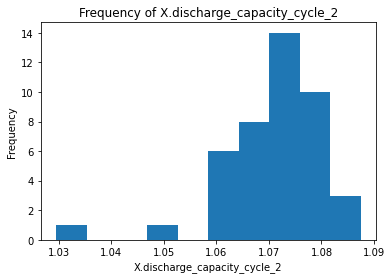

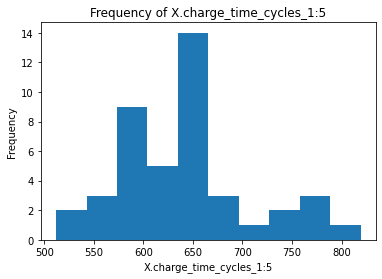

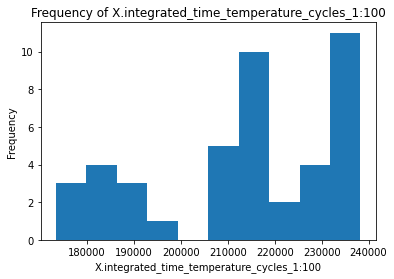

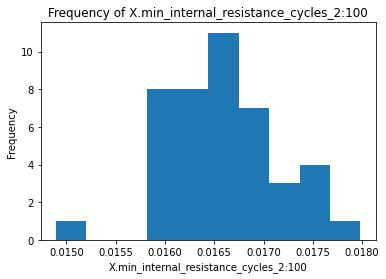

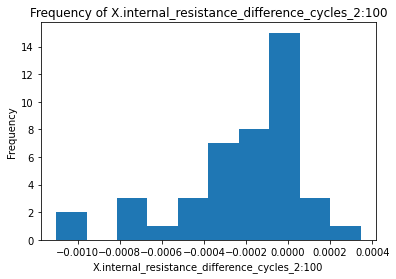

In [45]:
# All columns in X_test_full
for feature in X_test_full.columns:
    plt.hist(X_test_full[feature])
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.title("Frequency of " + feature)
    plt.show()

In [46]:
old_data_metrics = pd.DataFrame(data = {"Model & Source": ["Var (Linear)", "Var (E.N.)", "Var (Paper)",
                                                           "Disc (Linear)", "Disc (E.N.)", "Disc (Paper)",
                                                           "Full (Linear)", "Full (E.N.)", "Full (Paper)"],
                               
                               "Model": ["Variance", "Variance", "Variance",
                                         "Discharge", "Discharge", "Discharge",
                                         "Full", "Full", "Full"],
                                        
                               "Source": ["Us (Basic Linear)", "Us (Elastic Net)", "Paper (Elastic Net)",
                                          "Us (Basic Linear)", "Us (Elastic Net)", "Paper (Elastic Net)",
                                          "Us (Basic Linear)", "Us (Elastic Net)", "Paper (Elastic Net)"],
                                        
                               "Train RMSE": [rmse_train_var, rmse_train_var_en, 103,
                                              rmse_train_dis, rmse_train_dis_en, 76,
                                              rmse_train_full, rmse_train_full_en, 51],
                               
                               "Test RMSE": [rmse_test_var, rmse_test_var_en, 138,
                                             rmse_test_dis, rmse_test_dis_en, 91, 
                                             rmse_test_full, rmse_test_full_en, 118]})#,
                               
#                                "Mean % Train Error": [mape_train_var, 14.1,
#                                                       mape_train_dis, 9.8,
#                                                       mape_train_full, 5.6],
                               
#                                "Mean % Test Error": [mape_test_var, 14.7,
#                                                      mape_test_dis, 13.0,
#                                                      mape_test_full, 14.1]})

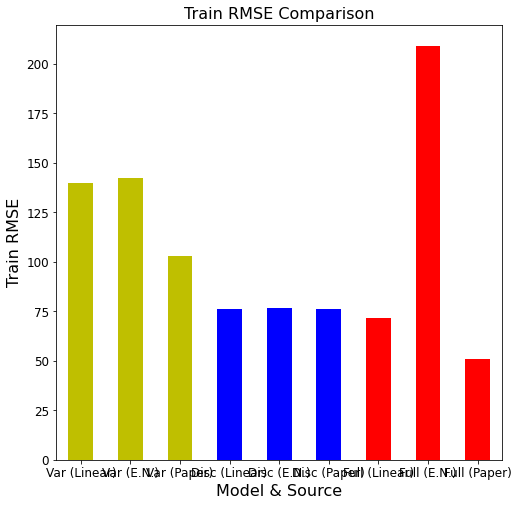

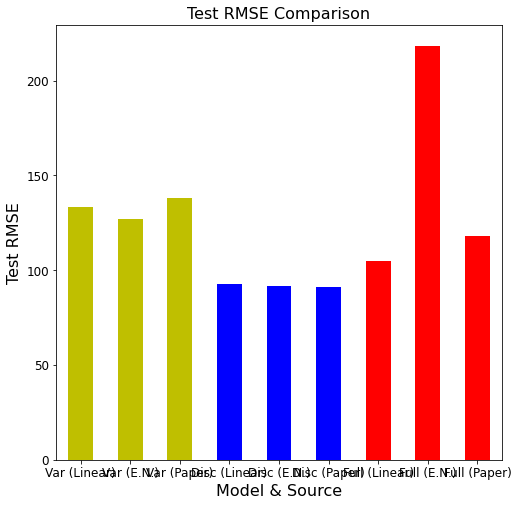

In [47]:
#better plots in chunk below
for column in old_data_metrics.columns[3:5]:
    ax = old_data_metrics.plot.bar(x='Model & Source', y=column, rot=0,
                         fontsize = 12, legend=False, figsize = (8,8),
                         color = ["y","y","y","b","b","b","r","r","r"])

    ax.set_xlabel("Model & Source", fontsize = 16)
    ax.set_ylabel(column, fontsize=16)
    ax.set_title(column + " Comparison", fontsize=16)
    plt.show()

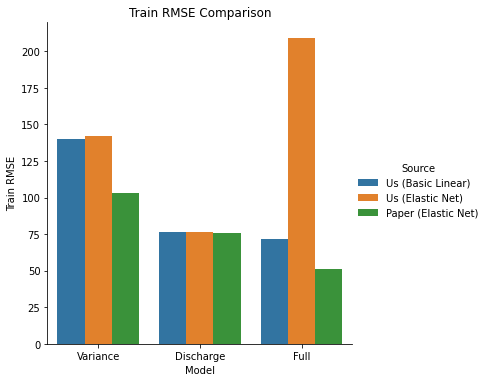

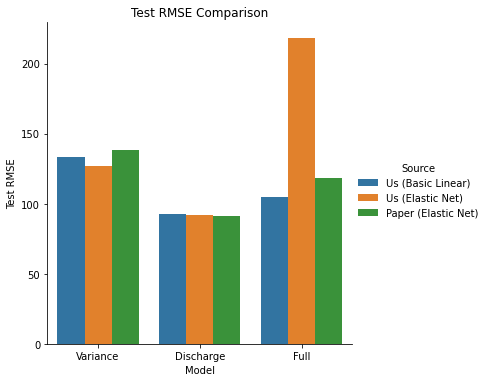

In [48]:
for column in old_data_metrics.columns[3:5]:
    sns.catplot(data = old_data_metrics, kind="bar",
               x = "Model", y = column, hue = "Source")
    plt.title(column + " Comparison")

In [49]:
old_data_rmse = pd.DataFrame([[round(rmse_test_var), 138, "Variance"],
                              [round(rmse_test_dis), 91, "Discharge"],
                              [round(rmse_test_full), 118, "Full"]],
                             columns = ["Our Model RMSE", "Paper Model RMSE", "Model"]
                            ).set_index("Model")
old_data_rmse

,Our Model RMSE,Paper Model RMSE
Model,,
Variance,133,138
Discharge,93,91
Full,105,118


__New Data Models__

In [50]:
from sklearn.model_selection import KFold
from sklearn.utils import resample
from matplotlib import pyplot as plt

<AxesSubplot:xlabel='X.abs_variance_discharge_capacity_difference_cycles_2:100', ylabel='charge_throughput'>

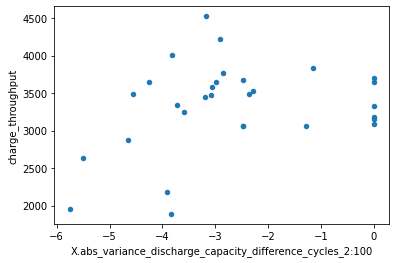

In [51]:
new_df_full.plot.scatter(x='X.abs_variance_discharge_capacity_difference_cycles_2:100', y = y)

In [52]:
# KFold 
splits = []
kf = KFold(n_splits=2,shuffle=True, random_state = 451)
for train_index, test_index in kf.split(new_df_full):
    splits.append((train_index,test_index))
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [ 3  4  5  6 11 12 13 14 17 20 22 24 27 28 29] TEST: [ 0  1  2  7  8  9 10 15 16 18 19 21 23 25 26]
TRAIN: [ 0  1  2  7  8  9 10 15 16 18 19 21 23 25 26] TEST: [ 3  4  5  6 11 12 13 14 17 20 22 24 27 28 29]


In [53]:
splits

[(array([ 3,  4,  5,  6, 11, 12, 13, 14, 17, 20, 22, 24, 27, 28, 29]),
  array([ 0,  1,  2,  7,  8,  9, 10, 15, 16, 18, 19, 21, 23, 25, 26])),
 (array([ 0,  1,  2,  7,  8,  9, 10, 15, 16, 18, 19, 21, 23, 25, 26]),
  array([ 3,  4,  5,  6, 11, 12, 13, 14, 17, 20, 22, 24, 27, 28, 29]))]

In [54]:
train_ind = splits[0][0]
test_ind = splits[0][1]

In [55]:
# Variance model
X_train_var = new_df_full.iloc[train_ind][[variance_model_features]]
y_train = new_df_full.iloc[train_ind][[y]]

X_test_var = new_df_full.iloc[test_ind][[variance_model_features]]
y_test = new_df_full.iloc[test_ind][[y]]

reg_var = LinearRegression().fit(X_train_var,y_train)
y_pred_train_var = reg_var.predict(X_train_var)
y_pred_test_var = reg_var.predict(X_test_var)

rmse_train_var = np.sqrt(mean_squared_error(y_train, y_pred_train_var))
rmse_test_var = np.sqrt(mean_squared_error(y_test, y_pred_test_var))
mape_train_var = mean_absolute_percentage_error(y_train, y_pred_train_var)
mape_test_var = mean_absolute_percentage_error(y_test, y_pred_test_var)

print("Variance Model")
print("Training RMSE: ", rmse_train_var)
print("Test RMSE: ", rmse_test_var)
print("Mean % Train Error: ", mape_train_var)
print("Mean % Test Error: ", mape_test_var)

Variance Model
Training RMSE:  496.34011349309236
Test RMSE:  612.3410009392428
Mean % Train Error:  0.12459997668270652
Mean % Test Error:  0.1725035765507392


In [56]:
k_fold = 5
l1_ratios = [i/20 for i in range(10, 21)]
max_iter = 1000000
random_state = 1
test_size = 2
tol = 0.0001

models = []
y_pred_trains = []
y_pred_tests = []
train_rmses = []
test_rmses = []

for l1_ratio in l1_ratios:
    elasticnetcv = ElasticNetCV(
        fit_intercept=True,
        normalize=False,
        alphas=None,
        cv=k_fold,
        l1_ratio=l1_ratio,
        max_iter=max_iter,
    )
    elasticnetcv.fit(X_train_var, y_train)

    elasticnet_var = ElasticNet(
        fit_intercept=True,
        normalize=False,
        l1_ratio=elasticnetcv.l1_ratio_,
        alpha=elasticnetcv.alpha_,
        max_iter=max_iter,
    )

    elasticnet_var.fit(X_train_var, y_train)
    y_pred_train_en_var = elasticnet_var.predict(X_train_var)
    y_pred_test_en_var = elasticnet_var.predict(X_test_var)

    rmse_train_en_var = np.sqrt(mean_squared_error(y_train, y_pred_train_en_var))
    rmse_test_en_var = np.sqrt(mean_squared_error(y_test, y_pred_test_en_var))
#     mape_train_en_var = mean_absolute_percentage_error(y_train, y_pred_train_en_var)
#     mape_test_en_var = mean_absolute_percentage_error(y_test, y_pred_test_en_var)

    models.append(elasticnet_var)
    y_pred_trains.append(y_pred_train_en_var)
    y_pred_tests.append(y_pred_test_en_var)
    train_rmses.append(rmse_train_en_var)
    test_rmses.append(rmse_test_en_var)

best_model_index = test_rmses.index(min(test_rmses))

elasticnet_var = models[best_model_index]
y_pred_train_en_var = y_pred_trains[best_model_index]
y_pred_test_en_var = y_pred_tests[best_model_index]
rmse_train_var_en = train_rmses[best_model_index]
rmse_test_var_en = test_rmses[best_model_index]
l1_ratio_var = l1_ratios[best_model_index]

print("Variance Elastic Net Model")
print("l1_ratio =", l1_ratio_var)
print("Test RMSE: ", rmse_test_var_en)

C:\Users\david\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\david\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\david\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\david\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

Variance Elastic Net Model
l1_ratio = 0.5
Test RMSE:  642.6603176727153


C:\Users\david\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


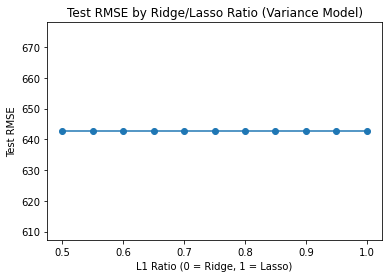

In [57]:
coeffs = np.polyfit(l1_ratios, test_rmses, 3)
vals = [coeffs[0]*val**3 + coeffs[1]*val**2 + coeffs[2]*val + coeffs[3] for val in l1_ratios]

plt.scatter(l1_ratios, test_rmses)
plt.plot(l1_ratios, vals)
plt.title("Test RMSE by Ridge/Lasso Ratio (Variance Model)")
plt.xlabel("L1 Ratio (0 = Ridge, 1 = Lasso)")
plt.ylabel("Test RMSE");

Text(0.5, 1.0, 'Variance Model Predicted vs. True Values')

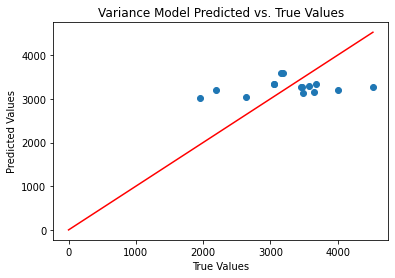

In [58]:
# Variance model
max_var = y_test.max()[0]

plt.scatter(y_test, y_pred_test_var)
plt.plot([0, max_var], [0, max_var], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Variance Model Predicted vs. True Values")

In [59]:
# discharge model
X_train_dis = new_df_full.iloc[train_ind][discharge_model_features]
X_train_dis = X_train_dis.replace([np.inf, -np.inf], np.nan)
X_train_dis.dropna(inplace = True)
X_train_dis_index = list(X_train_dis.index.values)

y_train = new_df_full.iloc[X_train_dis_index][[y]]

X_test_dis = new_df_full.iloc[test_ind][discharge_model_features]
X_test_dis = X_test_dis.replace([np.inf, -np.inf], np.nan)
X_test_dis.dropna(inplace = True)
X_test_dis_index = list(X_test_dis.index.values)

y_test = new_df_full.iloc[X_test_dis_index][[y]]

reg_dis = LinearRegression().fit(X_train_dis,y_train)
y_pred_train_dis = reg_dis.predict(X_train_dis)
y_pred_test_dis = reg_dis.predict(X_test_dis)

rmse_train_dis = np.sqrt(mean_squared_error(y_train, y_pred_train_dis))
rmse_test_dis = np.sqrt(mean_squared_error(y_test, y_pred_test_dis))
mape_train_dis = mean_absolute_percentage_error(y_train, y_pred_train_dis)
mape_test_dis = mean_absolute_percentage_error(y_test, y_pred_test_dis)

print("Discharge Model")
print("Training RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_train_dis)))
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_test_dis)))
print("Mean % Train Error: ", mean_absolute_percentage_error(y_train, y_pred_train_dis))
print("Mean % Test Error: ", mean_absolute_percentage_error(y_test, y_pred_test_dis))

Discharge Model
Training RMSE:  269.90297024697094
Test RMSE:  465.5696023688758
Mean % Train Error:  0.06539580476589178
Mean % Test Error:  0.12856625501028626


Text(0.5, 1.0, 'Discharge Model Predicted vs. True Values')

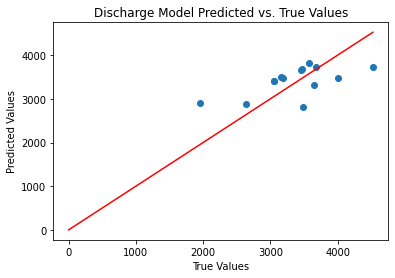

In [60]:
# Discharge model
max_dis = y_test.max()[0]

plt.scatter(y_test, y_pred_test_dis)
plt.plot([0, max_dis], [0, max_dis], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Discharge Model Predicted vs. True Values")

In [61]:
k_fold = 5
l1_ratios = [i/20 for i in range(10, 21)]
max_iter = 1000000
random_state = 1
test_size = 2
tol = 0.0001

models = []
y_pred_trains = []
y_pred_tests = []
train_rmses = []
test_rmses = []

for l1_ratio in l1_ratios:
    elasticnetcv = ElasticNetCV(
        fit_intercept=True,
        normalize=False,
        alphas=None,
        cv=k_fold,
        l1_ratio=l1_ratio,
        max_iter=max_iter,
    )
    elasticnetcv.fit(X_train_dis, y_train)

    elasticnet_dis = ElasticNet(
        fit_intercept=True,
        normalize=False,
        l1_ratio=elasticnetcv.l1_ratio_,
        alpha=elasticnetcv.alpha_,
        max_iter=max_iter,
    )

    elasticnet_dis.fit(X_train_dis, y_train)
    y_pred_train_en_dis = elasticnet_dis.predict(X_train_dis)
    y_pred_test_en_dis = elasticnet_dis.predict(X_test_dis)

    rmse_train_en_dis = np.sqrt(mean_squared_error(y_train, y_pred_train_en_dis))
    rmse_test_en_dis = np.sqrt(mean_squared_error(y_test, y_pred_test_en_dis))
#     mape_train_en_dis = mean_absolute_percentage_error(y_train, y_pred_train_en_dis)
#     mape_test_en_dis = mean_absolute_percentage_error(y_test, y_pred_test_en_dis)

    models.append(elasticnet_dis)
    y_pred_trains.append(y_pred_train_en_dis)
    y_pred_tests.append(y_pred_test_en_dis)
    train_rmses.append(rmse_train_en_dis)
    test_rmses.append(rmse_test_en_dis)

best_model_index = test_rmses.index(min(test_rmses))

elasticnet_dis = models[best_model_index]
y_pred_train_en_dis = y_pred_trains[best_model_index]
y_pred_test_en_dis = y_pred_tests[best_model_index]
rmse_train_dis_en = train_rmses[best_model_index]
rmse_test_dis_en = test_rmses[best_model_index]
l1_ratio_dis = l1_ratios[best_model_index]

print("Discharge Elastic Net Model")
print("l1_ratio =", l1_ratio_dis)
print("Test RMSE: ", rmse_test_dis_en)

C:\Users\david\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\david\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\david\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\david\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

Discharge Elastic Net Model
l1_ratio = 0.95
Test RMSE:  454.7117228068467


C:\Users\david\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


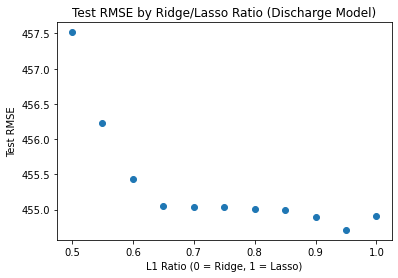

In [62]:
# coeffs = np.polyfit(l1_ratios, test_rmses, 3)
# vals = [coeffs[0]*val**3 + coeffs[1]*val**2 + coeffs[2]*val + coeffs[3] for val in l1_ratios[:-1]]

plt.scatter(l1_ratios, test_rmses)
# plt.plot(l1_ratios[:-1], vals)
plt.title("Test RMSE by Ridge/Lasso Ratio (Discharge Model)")
plt.xlabel("L1 Ratio (0 = Ridge, 1 = Lasso)")
plt.ylabel("Test RMSE");

In [63]:
# full model
X_train_full = new_df_full.iloc[train_ind][full_model_features]
X_train_full.replace(-np.Inf, np.nan, inplace = True)
X_train_full.dropna(inplace = True)
X_train_full_index = list(X_train_full.index.values)

y_train = new_df_full.iloc[X_train_full_index][[y]]

X_test_full = new_df_full.iloc[test_ind][full_model_features]
X_test_full.replace(-np.Inf, np.nan, inplace = True)
X_test_full.dropna(inplace = True)
X_test_full_index = list(X_test_full.index.values)

y_test = new_df_full.iloc[X_test_full_index][[y]]

reg_full = LinearRegression().fit(X_train_full,y_train)
y_pred_train_full = reg_full.predict(X_train_full)
y_pred_test_full = reg_full.predict(X_test_full)

rmse_train_full = np.sqrt(mean_squared_error(y_train, y_pred_train_full))
rmse_test_full = np.sqrt(mean_squared_error(y_test, y_pred_test_full))
mape_train_full = mean_absolute_percentage_error(y_train, y_pred_train_full)
mape_test_full = mean_absolute_percentage_error(y_test, y_pred_test_full)

print("Full Model")
print("Training RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_train_full)))
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_test_full)))
print("Mean % Train Error: ", mean_absolute_percentage_error(y_train, y_pred_train_full))
print("Mean % Test Error: ", mean_absolute_percentage_error(y_test, y_pred_test_full))

Full Model
Training RMSE:  227.2370817421009
Test RMSE:  554.8914923686302
Mean % Train Error:  0.04872060243542927
Mean % Test Error:  0.14489067546231427


Text(0.5, 1.0, 'Full Model Predicted vs. True Values')

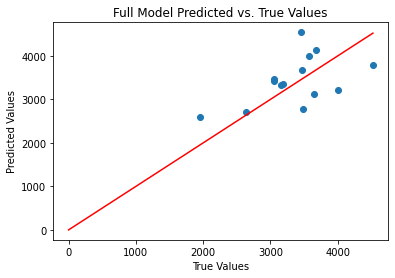

In [64]:
# full model
max_full = y_test.max()[0]

plt.scatter(y_test, y_pred_test_full)
plt.plot([0, max_full], [0, max_full], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Full Model Predicted vs. True Values")

In [65]:
k_fold = 5
l1_ratios = [i/20 for i in range(1, 21)]   #use this when testing different ratios
#l1_ratios = [0.8]   #use this when using only the best ratio
max_iter = 1000000
random_state = 1
test_size = 2
tol = 0.0001

models = []
y_pred_trains = []
y_pred_tests = []
train_rmses = []
test_rmses = []

for l1_ratio in l1_ratios:
    elasticnetcv = ElasticNetCV(
        fit_intercept=True,
        normalize=False,
        alphas=None,
        cv=k_fold,
        l1_ratio=l1_ratio,
        max_iter=max_iter,
    )
    elasticnetcv.fit(X_train_full, y_train)

    elasticnet_full = ElasticNet(
        fit_intercept=True,
        normalize=False,
        l1_ratio=elasticnetcv.l1_ratio_,
        alpha=elasticnetcv.alpha_,
        max_iter=max_iter,
    )

    elasticnet_full.fit(X_train_full, y_train)
    y_pred_train_en_full = elasticnet_full.predict(X_train_full)
    y_pred_test_en_full = elasticnet_full.predict(X_test_full)

    rmse_train_en_full = np.sqrt(mean_squared_error(y_train, y_pred_train_en_full))
    rmse_test_en_full = np.sqrt(mean_squared_error(y_test, y_pred_test_en_full))
#     mape_train_en_full = mean_absolute_percentage_error(y_train, y_pred_train_en_full)
#     mape_test_en_full = mean_absolute_percentage_error(y_test, y_pred_test_en_full)

    models.append(elasticnet_full)
    y_pred_trains.append(y_pred_train_en_full)
    y_pred_tests.append(y_pred_test_en_full)
    train_rmses.append(rmse_train_en_full)
    test_rmses.append(rmse_test_en_full)

best_model_index = test_rmses.index(min(test_rmses))

elasticnet_full = models[best_model_index]
y_pred_train_en_full = y_pred_trains[best_model_index]
y_pred_test_en_full = y_pred_tests[best_model_index]
rmse_train_full_en = train_rmses[best_model_index]
rmse_test_full_en = test_rmses[best_model_index]
l1_ratio_full = l1_ratios[best_model_index]

print("Full Elastic Net Model")
print("l1_ratio =", l1_ratio_full)
print("Test RMSE: ", rmse_test_full_en)

C:\Users\david\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\david\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\david\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\david\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

Full Elastic Net Model
l1_ratio = 0.05
Test RMSE:  598.8340710450241


C:\Users\david\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


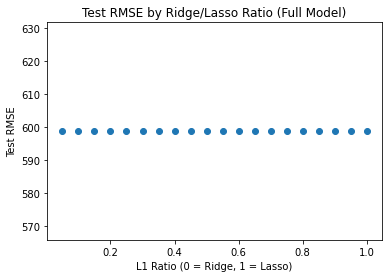

In [66]:
plt.scatter(l1_ratios, test_rmses)
plt.title("Test RMSE by Ridge/Lasso Ratio (Full Model)")
plt.xlabel("L1 Ratio (0 = Ridge, 1 = Lasso)")
plt.ylabel("Test RMSE");

__New Data Plots__

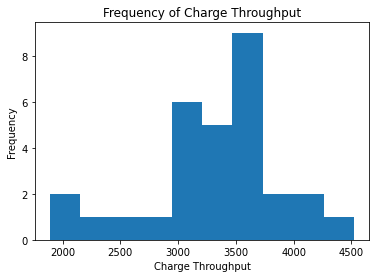

In [67]:
plt.hist(new_df_full[y])
plt.ylabel('Frequency')
if ct:
    plt.xlabel('Charge Throughput')
    plt.title('Frequency of Charge Throughput')
else:
    plt.xlabel('Cycle Life')
    plt.title('Frequency of Cycle Life')

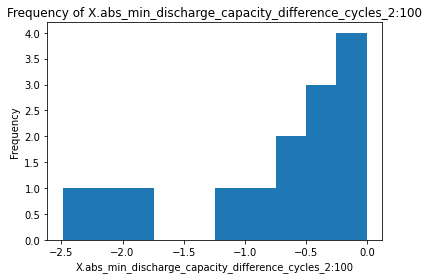

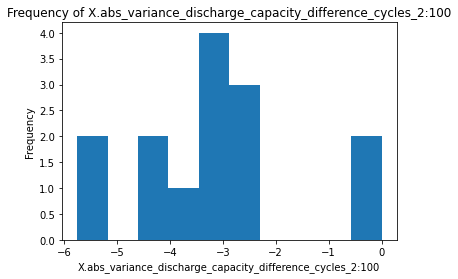

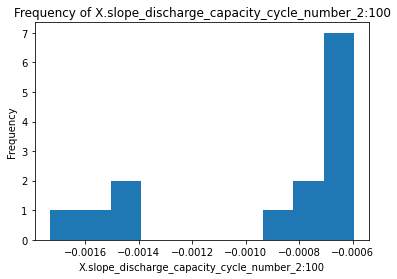

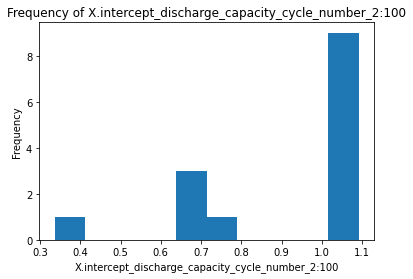

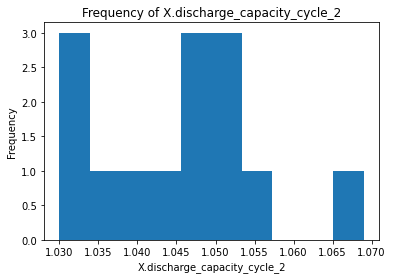

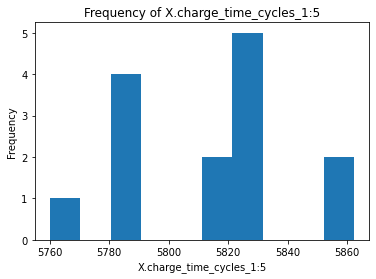

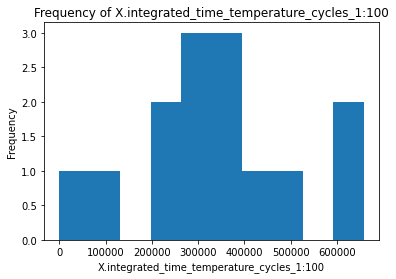

In [68]:
# All columns in X_test_full
for feature in X_test_full.columns:
    plt.hist(X_test_full[feature])
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.title("Frequency of " + feature)
    plt.show()

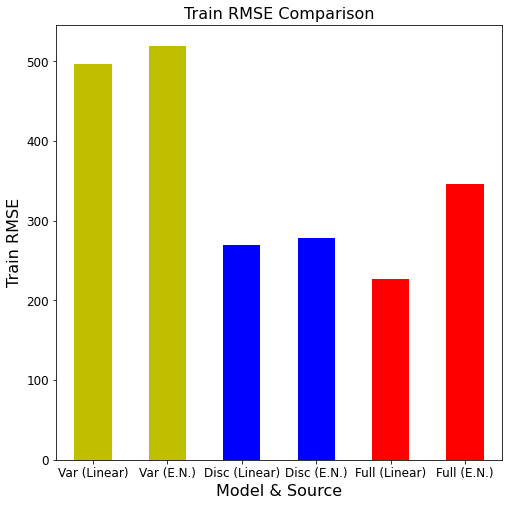

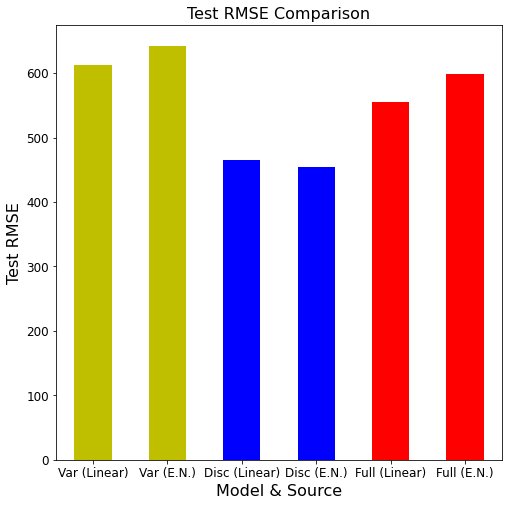

In [69]:
new_data_metrics = pd.DataFrame(data = {"Model & Source": ["Var (Linear)", "Var (E.N.)", 
                                                           "Disc (Linear)", "Disc (E.N.)",
                                                           "Full (Linear)", "Full (E.N.)"],
                               
                               "Model": ["Variance", "Variance",
                                         "Discharge", "Discharge",
                                         "Full", "Full"],
                                        
                               "Source": ["Basic Linear Regression", "Elastic Net",
                                          "Basic Linear Regression", "Elastic Net",
                                          "Basic Linear Regression", "Elastic Net"],
                                        
                               "Train RMSE": [rmse_train_var, rmse_train_var_en,
                                              rmse_train_dis, rmse_train_dis_en,
                                              rmse_train_full, rmse_train_full_en],
                               
                               "Test RMSE": [rmse_test_var, rmse_test_var_en,
                                             rmse_test_dis, rmse_test_dis_en,
                                             rmse_test_full, rmse_test_full_en,]})#,


for column in new_data_metrics.columns[3:]:
    ax = new_data_metrics.plot.bar(x='Model & Source', y=column, rot=0,
                         fontsize = 12, legend=False, figsize = (8,8),
                         color = ["y","y","b","b","r","r"])

    ax.set_xlabel("Model & Source", fontsize = 16)
    ax.set_ylabel(column, fontsize=16)
    ax.set_title(column + " Comparison", fontsize=16)
    plt.show()

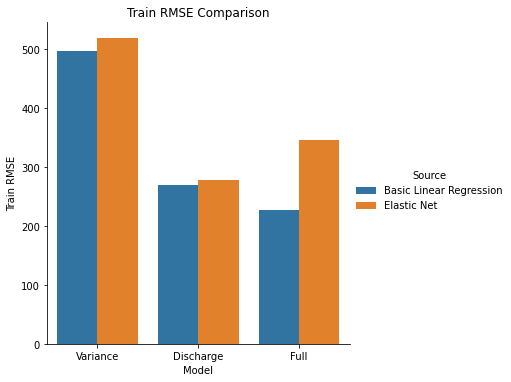

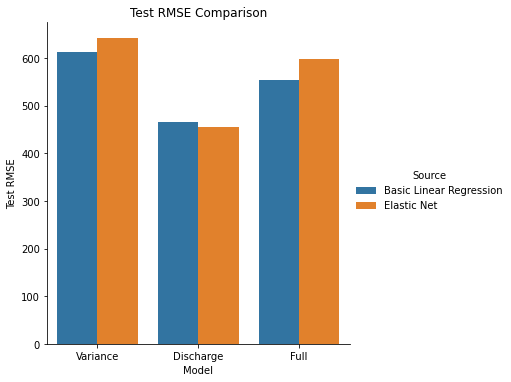

In [70]:
for column in new_data_metrics.columns[3:5]:
    sns.catplot(data = new_data_metrics, kind="bar",
               x = "Model", y = column, hue = "Source")
    plt.title(column + " Comparison")

In [71]:
pd.DataFrame([[round(rmse_test_var), round(rmse_test_var_en), "Variance"], 
              [round(rmse_test_dis), round(rmse_test_dis_en), "Discharge"], 
              [round(rmse_test_full), round(rmse_test_full_en), "Full"]], 
              columns = ["Basic Linear Regression RMSE", "Elastic Net RMSE", "Model"]
            ).set_index("Model")

,Basic Linear Regression RMSE,Elastic Net RMSE
Model,,
Variance,612,643
Discharge,466,455
Full,555,599


__Combined Plots__

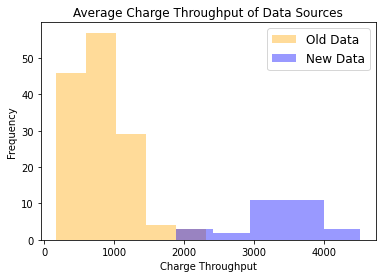

In [77]:
sns.distplot(old_df_full[y], kde=False, color="orange", label='Old Data', bins=5)
sns.distplot(new_df_full[y], kde=False, color="blue", label='New Data', bins=5)

# Plot formatting
plt.legend(prop={'size': 12})
if ct:
    plt.title('Average Charge Throughput of Data Sources')
    plt.xlabel('Charge Throughput')
else:
    plt.title('Average Cycle Life of Data Sources')
    plt.xlabel('Cycle Life')
plt.ylabel('Frequency');